<a href="https://colab.research.google.com/github/negbuna/models/blob/main/stock_price_movement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Use yfinance to get data
!pip install yfinance --quiet

In [49]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score


sns.set_theme(style="darkgrid")

In [29]:
# Define stock + time range
ticker = "AAPL"
data = yf.download(ticker, start="2022-04-01", end="2024-04-01")
# Flatten MultiIndex columns
data.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in data.columns]
data.head()

[*********************100%***********************]  1 of 1 completed


,Close_AAPL,High_AAPL,Low_AAPL,Open_AAPL,Volume_AAPL
Date,,,,,
2022-04-01,171.530563,172.091482,169.198359,171.255029,78751300
2022-04-04,175.594742,175.643948,171.658523,171.786455,76468400
2022-04-05,172.268646,175.456989,171.638852,174.669743,73401800
2022-04-06,169.090149,170.861451,167.417259,169.611697,89058800
2022-04-07,169.395203,170.595751,167.141724,168.430833,77594700


plotting closing price

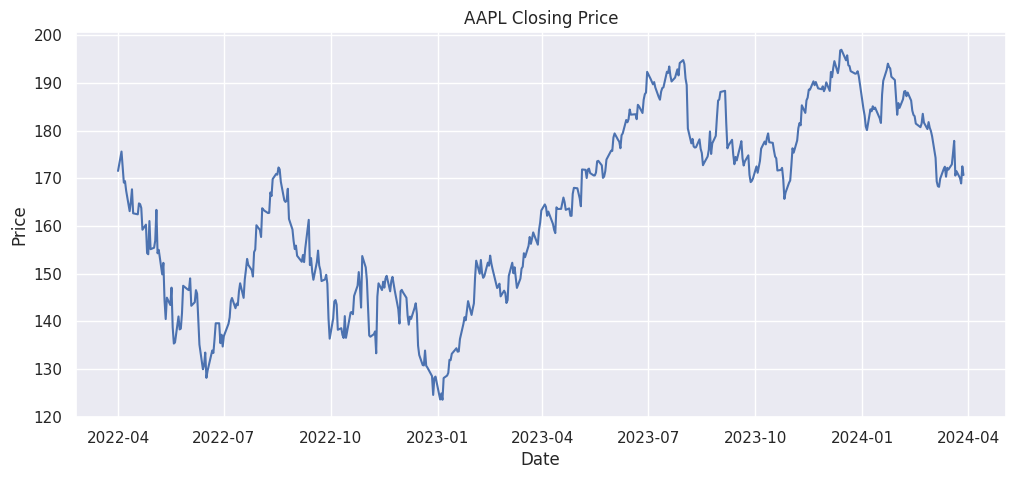

In [31]:
plt.figure(figsize=(12, 5))
plt.plot(data['Close_AAPL'])
plt.title(f'{ticker} Closing Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [32]:
# Compare today's price to tmrw's price; if true return 1
data['Target'] = np.where(data['Close_AAPL'].shift(-1) > data['Close_AAPL'], 1, 0)
data = data[:-1] # Can't compare last day with last day + 1
data[['Close_AAPL', 'Target']].tail()

,Close_AAPL,Target
Date,,
2024-03-21,170.564621,1
2024-03-22,171.470337,0
2024-03-25,170.047089,0
2024-03-26,168.912415,1
2024-03-27,172.495499,0


In [34]:
data['Daily Change'] = data['Close_AAPL'] - data['Open_AAPL']
data['Daily Change'].tail()

,Daily Change
Date,
2024-03-21,-5.653314
2024-03-22,0.517560
2024-03-25,0.278683
2024-03-26,-0.288630
2024-03-27,2.886365


In [35]:
data['Percent Change'] = (data['Close_AAPL'] - data['Open_AAPL']) / data['Open_AAPL']
data['Percent Change'].tail()

,Percent Change
Date,
2024-03-21,-0.032081
2024-03-22,0.003028
2024-03-25,0.001642
2024-03-26,-0.001706
2024-03-27,0.017018


In [37]:
data['Volatility'] = data['Close_AAPL'].rolling(5).std()
data['Volatility'].tail()

,Volatility
Date,
2024-03-21,2.894288
2024-03-22,2.952130
2024-03-25,3.368641
2024-03-26,3.514411
2024-03-27,1.365403


In [39]:
# 5 day moving avg
data['MA5'] = data['Close_AAPL'].rolling(5).mean()
data['MA5'].tail()

,MA5
Date,
2024-03-21,173.671954
2024-03-22,173.604272
2024-03-25,173.032974
2024-03-26,171.764957
2024-03-27,170.697992


In [46]:
# Adding lagged features
data['Lag1'] = data['Close_AAPL'].shift(1)  # Price from the previous day
data['Lag2'] = data['Close_AAPL'].shift(2)  # Price from 2 days ago
data['Lag3'] = data['Close_AAPL'].shift(3)  # Price from 3 days ago

# Drop NaN values from shifting
data.dropna(subset=['Lag1', 'Lag2', 'Lag3'], inplace=True)

In [50]:
X = data[['Close_AAPL', 'Daily Change', 'Volume_AAPL', 'Lag1', 'Lag2', 'Lag3']]
y = data['Target']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
model = XGBClassifier()
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

# train model
# model.fit(X_train, y_train)

# make predictions
# y_pred = model.predict(X_test)

# evaluate model
#accuracy = accuracy_score(y_test, y_pred)
#print(f'Accuracy: {accuracy}')

y_pred_rf = rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy with Random Forest: {accuracy_rf}")
print(f"Precision: {precision_score(y_test, y_pred_rf)}")
print(f"Recall: {recall_score(y_test, y_pred_rf)}")
print(f"F1 Score: {f1_score(y_test, y_pred_rf)}")

Accuracy with Random Forest: 0.49
Precision: 0.46296296296296297
Recall: 0.5319148936170213
F1 Score: 0.49504950495049505
